#📌 Extracción

In [57]:
# Requisitos: pandas, matplotlib, plotly

import json
import os
import traceback
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# ----------------- 1) EXTRACCIÓN -----------------
def extract(json_path='/content/TelecomX_Data.json'):
    if not os.path.isfile(json_path):
        raise FileNotFoundError(f"No se encontró el archivo JSON en: {json_path}")
    with open(json_path, 'r', encoding='utf-8') as f:
        raw = json.load(f)
    df = pd.json_normalize(raw, sep='_')
    return raw, df

df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [58]:
# ----------------- 2) TRANSFORMACIÓN -----------------
def transform(df):
    df = df.copy()
    df.columns = [c.replace('customer.', 'cust_').replace('phone.', 'phone_')
                     .replace('internet.', 'net_').replace('account.', 'acct_')
                     .replace('Charges.', 'charges_').replace('account_Charges.', 'charges_')
                     for c in df.columns]

    def find_col(cols, patterns):
        for p in patterns:
            for c in cols:
                if p.lower() in c.lower():
                    return c
        return None

    monthly_col = find_col(df.columns, ['monthly_charge','monthly','charges_monthly','charges_Monthly'])
    total_col   = find_col(df.columns, ['total_charge','total','charges_total','Charges.Total','charges_Total'])
    tenure_col  = find_col(df.columns, ['tenure','cust_tenure','customer_tenure'])
    payment_col = find_col(df.columns, ['paymentmethod','payment_method','acct_paymentmethod'])
    paperless_col = find_col(df.columns, ['paperless','paperless_billing','acct_paperlessbilling'])

    rename_map = {}
    if monthly_col: rename_map[monthly_col] = 'monthly_charge'
    if total_col: rename_map[total_col] = 'total_charge'
    if tenure_col: rename_map[tenure_col] = 'tenure'
    if payment_col: rename_map[payment_col] = 'payment_method'
    if paperless_col: rename_map[paperless_col] = 'paperless_billing'
    if 'customerID' in df.columns: rename_map['customerID'] = 'customer_id'
    if 'Churn' in df.columns: rename_map['Churn'] = 'churn'

    df = df.rename(columns=rename_map)

    for col in ['monthly_charge','total_charge','tenure']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')

    if 'monthly_charge' in df.columns and 'tenure' in df.columns:
        df['expected_total'] = df['monthly_charge'] * df['tenure']
    else:
        df['expected_total'] = pd.NA

    df['diff_expected_minus_total'] = df['expected_total'] - df['total_charge']
    df['ratio_total_expected'] = df.apply(
        lambda r: (r['total_charge'] / r['expected_total']) if pd.notna(r['expected_total']) and r['expected_total'] != 0 else pd.NA,
        axis=1
    )

    df['missing_total'] = df['total_charge'].isna()
    df['missing_monthly'] = df['monthly_charge'].isna()
    df['missing_tenure'] = df['tenure'].isna()

    if 'payment_method' in df.columns:
        df['payment_method'] = df['payment_method'].astype(str).str.strip().str.lower()

    def suspicious_row(r, ratio_thr=0.75, missing_months_mult=2):
        try:
            if pd.isna(r['expected_total']) or pd.isna(r['total_charge']) or pd.isna(r['monthly_charge']):
                return False
            if r['expected_total'] == 0:
                return True
            ratio = r['ratio_total_expected']
            diff = r['diff_expected_minus_total']
            tenure_ok = (r['tenure'] >= 3) if pd.notna(r['tenure']) else False
            cond_ratio = pd.notna(ratio) and ratio < ratio_thr and tenure_ok
            cond_missing_months = pd.notna(diff) and pd.notna(r['monthly_charge']) and diff > (missing_months_mult * r['monthly_charge']) and tenure_ok
            return bool(cond_ratio or cond_missing_months)
        except Exception:
            return False

    df['suspicious_evasion_flag'] = df.apply(suspicious_row, axis=1)

    def reason_for_flag(r):
        reasons = []
        if r.get('missing_total', False): reasons.append('missing total')
        if r.get('missing_monthly', False): reasons.append('missing monthly')
        try:
            if pd.notna(r.get('ratio_total_expected')) and r['ratio_total_expected'] < 0.75 and r.get('tenure', 0) >= 3:
                reasons.append(f'paid <75% expected (ratio={r["ratio_total_expected"]:.2f})')
        except Exception:
            pass
        try:
            if pd.notna(r.get('diff_expected_minus_total')) and pd.notna(r.get('monthly_charge')) and r['diff_expected_minus_total'] > 2 * r['monthly_charge'] and r.get('tenure', 0) >= 3:
                reasons.append(f'gap >2 months (gap={r["diff_expected_minus_total"]:.2f})')
        except Exception:
            pass
        return '; '.join(reasons) if reasons else ''

    df['suspicion_reasons'] = df.apply(reason_for_flag, axis=1)
    return df

df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#📊 Carga y análisis

In [53]:
# ----------------- 3) CARGA Y ANÁLISIS -----------------
def load_and_analyze(df, output_dir='/content/sample_data'):
    os.makedirs(output_dir, exist_ok=True)
    full_csv = os.path.join(output_dir, 'telecomx_full_transformed.csv')
    df.to_csv(full_csv, index=False)

    pm_summary = pd.DataFrame()
    if 'payment_method' in df.columns:
        pm_summary = (df.groupby('payment_method')['suspicious_evasion_flag']
                        .agg(['count','sum','mean'])
                        .rename(columns={'count':'n_customers','sum':'n_suspects','mean':'suspect_rate'}))
        pm_summary = pm_summary.sort_values('n_suspects', ascending=False)
        pm_summary.to_csv(os.path.join(output_dir, 'payment_method_suspects_summary.csv'))

    total_customers = len(df)
    n_suspects = int(df['suspicious_evasion_flag'].sum())
    suspect_pct = n_suspects / total_customers if total_customers else 0.0

    # Histograma matplotlib
    hist_png = None
    try:
        ratios = df['ratio_total_expected'].dropna()
        if not ratios.empty:
            fig_hist, ax = plt.subplots(figsize=(8,5))
            ax.hist(ratios, bins=30)
            ax.set_title('Distribución ratio (total_reportado / total_esperado)')
            ax.set_xlabel('Ratio total / expected')
            ax.set_ylabel('Cantidad de clientes')
            hist_png = os.path.join(output_dir, 'hist_ratio_total_expected.png')
            fig_hist.savefig(hist_png, bbox_inches='tight')
            plt.close(fig_hist)
    except Exception:
        hist_png = None

    # Scatter plotly
    scatter_html = None
    try:
        if 'tenure' in df.columns and 'diff_expected_minus_total' in df.columns:
            scatter_df = df.dropna(subset=['tenure','diff_expected_minus_total']).copy()
            if not scatter_df.empty:
                scatter_df['suspicion_label'] = scatter_df['suspicious_evasion_flag'].map({True:'sospechoso', False:'no'})
                fig_scatter = px.scatter(
                    scatter_df,
                    x='tenure',
                    y='diff_expected_minus_total',
                    color='suspicion_label',
                    hover_data=['customer_id','monthly_charge','total_charge','payment_method','ratio_total_expected'],
                    title='Tenure vs Gap (expected - reportado). Color = sospecha'
                )
                scatter_html = os.path.join(output_dir, 'scatter_tenure_vs_gap.html')
                fig_scatter.write_html(scatter_html)
    except Exception:
        scatter_html = None

    # Bar plotly por metodo de pago
    bar_html = None
    try:
        if not pm_summary.empty:
            pm_df = pm_summary.reset_index()
            fig_bar = px.bar(pm_df, x='payment_method', y='n_suspects',
                            hover_data=['n_customers','suspect_rate'], title='Número de sospechosos por método de pago')
            bar_html = os.path.join(output_dir, 'bar_suspects_by_payment_method.html')
            fig_bar.write_html(bar_html)
    except Exception:
        bar_html = None

    suspects_df = df[df['suspicious_evasion_flag']].copy()
    suspects_csv = os.path.join(output_dir, 'suspect_customers.csv')
    suspects_df.to_csv(suspects_csv, index=False)

    analysis_summary = {
        'total_customers': total_customers,
        'n_suspects': n_suspects,
        'suspect_pct': float(suspect_pct),
        'full_csv': full_csv,
        'suspects_csv': suspects_csv,
        'hist_png': hist_png,
        'scatter_html': scatter_html,
        'bar_html': bar_html,
        'pm_summary_csv': os.path.join(output_dir, 'payment_method_suspects_summary.csv') if not pm_summary.empty else None
    }
    return analysis_summary, pm_summary, suspects_df

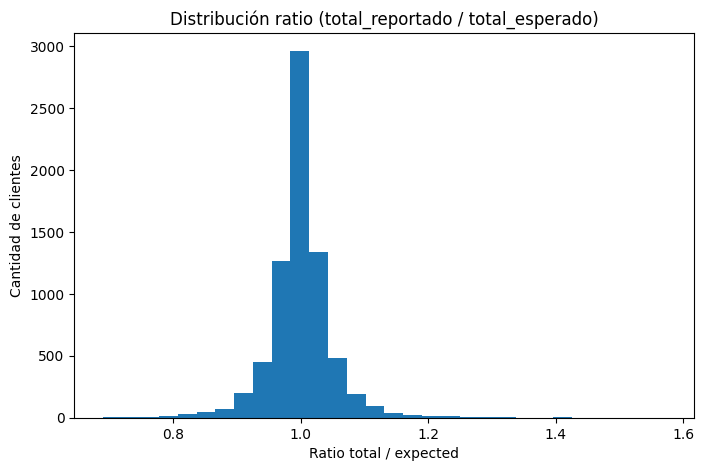

In [63]:
from IPython.display import Image, display
display(Image('/content/sample_data/hist_ratio_total_expected.png'))


In [64]:
from IPython.display import IFrame
# Scatter interactivo
display(IFrame('/content/sample_data/scatter_tenure_vs_gap.html', width='900', height='550'))
# Barra por método de pago
display(IFrame('/content/sample_data/bar_suspects_by_payment_method.html', width='900', height='500'))

In [65]:
from IPython.core.display import HTML, display
with open('/content/sample_data/scatter_tenure_vs_gap.html', 'r', encoding='utf-8') as f:
    html = f.read()
display(HTML(html))


Output hidden; open in https://colab.research.google.com to view.

In [72]:
import pandas as pd
suspects = pd.read_csv('/content/sample_data/suspect_customers.csv')
# Mostrar primeras filas y columnas relevantes
suspects[['customer_id','tenure','monthly_charge','total_charge','expected_total','diff_expected_minus_total','payment_method','suspicion_reasons']].head(20)


,customer_id,tenure,monthly_charge,total_charge,expected_total,diff_expected_minus_total,payment_method,suspicion_reasons
0,0048-PIHNL,49,20.45,900.90,1002.05,101.15,bank transfer (automatic),gap >2 months (gap=101.15)
1,0120-YZLQA,71,19.90,1355.10,1412.90,57.80,credit card (automatic),gap >2 months (gap=57.80)
2,0201-MIBOL,66,102.40,6471.85,6758.40,286.55,bank transfer (automatic),gap >2 months (gap=286.55)
3,0254-FNMCI,72,109.90,7624.20,7912.80,288.60,electronic check,gap >2 months (gap=288.60)
4,0266-CLZKZ,67,105.65,6717.90,7078.55,360.65,bank transfer (automatic),gap >2 months (gap=360.65)
5,0289-IVARM,35,60.55,1982.60,2119.25,136.65,electronic check,gap >2 months (gap=136.65)
6,0303-UNCIP,41,65.00,2531.80,2665.00,133.20,mailed check,gap >2 months (gap=133.20)
7,0334-ZFJSR,55,66.05,3462.10,3632.75,170.65,credit card (automatic),gap >2 months (gap=170.65)
8,0402-CQAJN,37,101.90,3545.35,3770.30,224.95,bank transfer (automatic),gap >2 months (gap=224.95)
9,0402-OAMEN,72,24.45,1709.10,1760.40,51.30,bank transfer (automatic),gap >2 months (gap=51.30)


In [68]:
import plotly.express as px
df = pd.read_csv('/content/sample_data/telecomx_full_transformed.csv')
# Asegúrate de convertir columnas numéricas si es necesario
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['diff_expected_minus_total'] = pd.to_numeric(df['diff_expected_minus_total'], errors='coerce')

fig = px.scatter(
    df.dropna(subset=['tenure','diff_expected_minus_total']),
    x='tenure',
    y='diff_expected_minus_total',
    color=df['suspicious_evasion_flag'].map({True:'sospechoso', False:'no'}),
    hover_data=['customer_id','monthly_charge','total_charge','payment_method','ratio_total_expected'],
    title='Tenure vs Gap (expected - reportado). Color = sospecha'
)
fig.show()


ValueError: All arguments should have the same length. The length of argument `color` is 7267, whereas the length of  previously-processed arguments ['tenure', 'diff_expected_minus_total', 'customer_id', 'monthly_charge', 'total_charge', 'payment_method', 'ratio_total_expected'] is 7256

In [69]:
pm = pd.read_csv('/content/sample_data/payment_method_suspects_summary.csv', index_col=0)
pm = pm.reset_index().rename(columns={'index':'payment_method'})  # en caso de que el csv tenga el método como índice
import plotly.express as px
fig = px.bar(pm, x='payment_method', y='n_suspects', hover_data=['n_customers','suspect_rate'],
             title='Número de sospechosos por método de pago')
fig.show()


In [71]:
df_full = pd.read_csv('/content/sample_data/telecomx_full_transformed.csv')
df_full.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7267,7267,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
churn,7043,2,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_gender,7267,2,Male,3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_SeniorCitizen,7267.0,NaN,NaN,NaN,0.162653,0.369074,0.0,0.0,0.0,0.0,1.0
customer_Partner,7267,2,No,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_Dependents,7267,2,No,5086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7267.0,NaN,NaN,NaN,32.346498,24.571773,0.0,9.0,29.0,55.0,72.0
phone_PhoneService,7267,2,Yes,6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone_MultipleLines,7267,3,No,3495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet_InternetService,7267,3,Fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#📄Informe final

In [54]:

# ----------------- 4) INFORME -----------------
def generate_report(analysis_summary, pm_summary, suspects_df, df, output_dir='/content/sample_data'):
    os.makedirs(output_dir, exist_ok=True)
    report_md_path = os.path.join(output_dir, 'evasion_report.md')
    ts = datetime.utcnow().isoformat()

    lines = []
    lines.append(f"# Informe: Detección inicial de evasión — TelecomX")
    lines.append(f"Generado: {ts} UTC\n")
    lines.append("## Resumen ejecutivo")
    lines.append(f"- Total clientes analizados: **{analysis_summary['total_customers']}**")
    lines.append(f"- Clientes marcados como sospechosos: **{analysis_summary['n_suspects']}** ({analysis_summary['suspect_pct']*100:.2f}%)\n")
    lines.append("## Archivos generados")
    for k,v in analysis_summary.items():
        if v:
            lines.append(f"- {k}: {v}")
    lines.append("\n## Top 20 sospechosos por gap")
    top20 = suspects_df.sort_values('diff_expected_minus_total', ascending=False).head(20)
    if not top20.empty:
        lines.append(top20[['customer_id','tenure','monthly_charge','total_charge','expected_total','diff_expected_minus_total','payment_method','suspicion_reasons']].to_markdown(index=False))
    else:
        lines.append("- No hay clientes sospechosos para mostrar.")

    with open(report_md_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

    return report_md_path

# ----------------- run_pipeline -----------------
def run_pipeline(json_path='//content/TelecomX_Data.json', output_dir='/content/sample_data'):
    try:
        raw, df0 = extract(json_path)
        df = transform(df0)
        analysis_summary, pm_summary, suspects_df = load_and_analyze(df, output_dir=output_dir)
        report_path = generate_report(analysis_summary, pm_summary, suspects_df, df, output_dir=output_dir)
        print("Pipeline completado correctamente.")
        print(f"- Informe: {report_path}")
        print(f"- CSV sospechosos: {analysis_summary['suspects_csv']}")
        print(f"- Visualizaciones (si generadas) en: {output_dir}")
        return {
            'report': report_path,
            'analysis_summary': analysis_summary,
            'pm_summary': pm_summary,
            'suspects_df': suspects_df
        }
    except Exception as e:
        print("Ocurrió un error durante la ejecución del pipeline:")
        traceback.print_exc()
        raise

# ----------------- EJECUTAR -----------------
if __name__ == '__main__':
    results = run_pipeline(json_path='//content/TelecomX_Data.json', output_dir='/content/sample_data')

Pipeline completado correctamente.
- Informe: /content/sample_data/evasion_report.md
- CSV sospechosos: /content/sample_data/suspect_customers.csv
- Visualizaciones (si generadas) en: /content/sample_data


In [73]:
from IPython.display import Markdown, display
with open('/content/sample_data/evasion_report.md', 'r', encoding='utf-8') as f:
    md = f.read()
display(Markdown(md))


# Informe: Detección inicial de evasión — TelecomX
Generado: 2025-08-11T18:38:32.881519 UTC

## Resumen ejecutivo
- Total clientes analizados: **7267**
- Clientes marcados como sospechosos: **302** (4.16%)

## Archivos generados
- total_customers: 7267
- n_suspects: 302
- suspect_pct: 0.04155772670978396
- full_csv: /content/sample_data/telecomx_full_transformed.csv
- suspects_csv: /content/sample_data/suspect_customers.csv
- hist_png: /content/sample_data/hist_ratio_total_expected.png
- scatter_html: /content/sample_data/scatter_tenure_vs_gap.html
- bar_html: /content/sample_data/bar_suspects_by_payment_method.html
- pm_summary_csv: /content/sample_data/payment_method_suspects_summary.csv

## Top 20 sospechosos por gap
| customer_id   |   tenure |   monthly_charge |   total_charge |   expected_total |   diff_expected_minus_total | payment_method            | suspicion_reasons          |
|:--------------|---------:|-----------------:|---------------:|-----------------:|----------------------------:|:--------------------------|:---------------------------|
| 3963-RYFNS    |       72 |           116.45 |        8013.55 |          8384.4  |                      370.85 | bank transfer (automatic) | gap >2 months (gap=370.85) |
| 0266-CLZKZ    |       67 |           105.65 |        6717.9  |          7078.55 |                      360.65 | bank transfer (automatic) | gap >2 months (gap=360.65) |
| 4612-THJBS    |       56 |           104.75 |        5510.65 |          5866    |                      355.35 | bank transfer (automatic) | gap >2 months (gap=355.35) |
| 0895-DQHEW    |       54 |           104.3  |        5278.15 |          5632.2  |                      354.05 | electronic check          | gap >2 months (gap=354.05) |
| 3258-SYSWS    |       72 |           113.8  |        7845.8  |          8193.6  |                      347.8  | bank transfer (automatic) | gap >2 months (gap=347.80) |
| 7176-WRTNX    |       70 |           114.95 |        7711.25 |          8046.5  |                      335.25 | bank transfer (automatic) | gap >2 months (gap=335.25) |
| 4342-HFXWS    |       48 |            69.7  |        3023.65 |          3345.6  |                      321.95 | bank transfer (automatic) | gap >2 months (gap=321.95) |
| 2235-EZAIK    |       72 |            79.2  |        5401.9  |          5702.4  |                      300.5  | credit card (automatic)   | gap >2 months (gap=300.50) |
| 9558-IHEZX    |       71 |           106.75 |        7283.25 |          7579.25 |                      296    | credit card (automatic)   | gap >2 months (gap=296.00) |
| 0254-FNMCI    |       72 |           109.9  |        7624.2  |          7912.8  |                      288.6  | electronic check          | gap >2 months (gap=288.60) |
| 0201-MIBOL    |       66 |           102.4  |        6471.85 |          6758.4  |                      286.55 | bank transfer (automatic) | gap >2 months (gap=286.55) |
| 2957-JIRMN    |       62 |            84.45 |        4959.15 |          5235.9  |                      276.75 | electronic check          | gap >2 months (gap=276.75) |
| 6048-UWKAL    |       69 |           105.4  |        6998.95 |          7272.6  |                      273.65 | credit card (automatic)   | gap >2 months (gap=273.65) |
| 1555-DJEQW    |       70 |           114.2  |        7723.9  |          7994    |                      270.1  | bank transfer (automatic) | gap >2 months (gap=270.10) |
| 4753-PADAS    |       67 |           105.7  |        6816.95 |          7081.9  |                      264.95 | bank transfer (automatic) | gap >2 months (gap=264.95) |
| 4060-BTPXO    |       67 |           105.7  |        6816.95 |          7081.9  |                      264.95 | bank transfer (automatic) | gap >2 months (gap=264.95) |
| 6173-GOLSU    |       67 |            94.65 |        6079    |          6341.55 |                      262.55 | credit card (automatic)   | gap >2 months (gap=262.55) |
| 3413-DHLPB    |       60 |           103.75 |        5969.95 |          6225    |                      255.05 | bank transfer (automatic) | gap >2 months (gap=255.05) |
| 7113-HIPFI    |       66 |            65.85 |        4097.05 |          4346.1  |                      249.05 | mailed check              | gap >2 months (gap=249.05) |
| 3612-YUNGG    |       64 |           109.2  |        6741.15 |          6988.8  |                      247.65 | credit card (automatic)   | gap >2 months (gap=247.65) |